In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import read_parquet
%matplotlib inline

In [92]:
pred_path = "/data/renhaoye/decals_2022/out_decals_pred_9_015.csv"    # 预测出来的位置
decals_pred = pd.read_csv(pred_path)
# 整理为dataframe
decals_pred['dec'] = decals_pred['loc']
decals_pred = decals_pred.drop(columns="time_cost")
label = decals_pred.pop('label')
decals_pred.insert(2,'label', label)
decals_pred = decals_pred.rename(columns={"loc":"ra"})
resolution = 6
decals_pred.ra = decals_pred.ra.map(lambda x: float(str(x).split("/data/renhaoye/decals_2022/out_decals/normalized_dat/")[1].split("_0.262_grz_raw.dat")[0].split("_")[0]))
decals_pred.dec = decals_pred.dec.map(lambda x: float(str(x).split("/data/renhaoye/decals_2022/out_decals/normalized_dat/")[1].split("_0.262_grz_raw.dat")[0].split("_")[1]))
decals_pred.ra = decals_pred.ra.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution]))
decals_pred.dec = decals_pred.dec.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution]))

In [95]:
label = list(np.array(decals_pred.label))
set_out_decals=set(label)
count_out_decals={}
for item in set_out_decals:
    count_out_decals.update({item:label.count(item)})
sum_out_decals = 312647
count_in_decals={"merger":7241, "rounded":69436, "inBetween":113932, "cigar":26574, "edgeOn":15193, "no/weakBar":42156, "strongBar":4042}
sum_in_decals = 7241+69436+113932+26574+15193+42156+4042

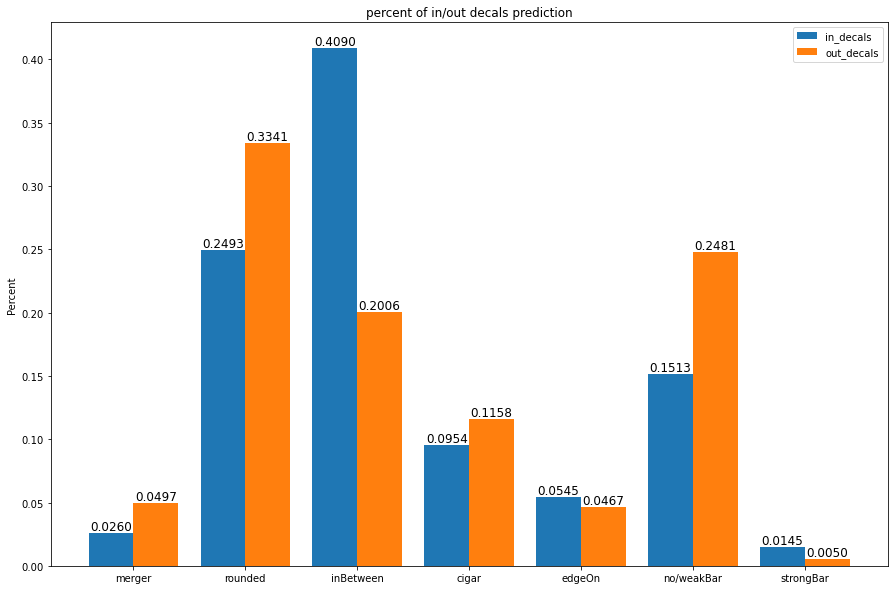

In [96]:
labels = list(count_in_decals.keys())
percent_in_decals = [x/sum_in_decals for x in list(count_in_decals.values())]
percent_out_decals = [x/sum_out_decals for x in list(count_out_decals.values())]
width = 0.4
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
rects2 = ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
ax.set_ylabel('Percent')
ax.set_title('percent of in/out decals prediction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x,percent_in_decals): ##控制标签位置
    plt.text(a-width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
for a,b in zip(x,percent_out_decals): ##控制标签位置
    plt.text(a+width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
ax.legend()
plt.show()

In [5]:
from astropy.io import fits
from tqdm import tqdm
with fits.open("/data/renhaoye/decals_2022/MGS_out_DECaLS.fits") as hdul:
    data = np.array(hdul[1].data)
    out = np.zeros((data.shape[0],10))
    # [('VID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('PETROMAG', '>f8', (5,)), ('MODELMAG', '>f8', (5,)), ('FIBERMAG', '>f8', (5,)), ('VAGC_SELECT', '>i4'), ('KCORRECT', '>f8', (5,)), ('Z', '>f8'), ('ZFLAG', '>f8')]
    for i in tqdm(range(data.shape[0])):
        out[i,0] = data[i]["VID"]
        out[i,1] = data[i]["RA"]
        out[i,2] = data[i]["DEC"]
        out[i,3] = data[i]["PETROMAG"][3]
        out[i,4] = data[i]["MODELMAG"][3]
        out[i,5] = data[i]["FIBERMAG"][3]
        out[i,6] = data[i]["VAGC_SELECT"]
        out[i,7] = data[i]["KCORRECT"][3]
        out[i,8] = data[i]["Z"]
        out[i,9] = data[i]["ZFLAG"]
out = pd.DataFrame(out, columns=["VID","ra","dec","petro_mag","model_mag","fiber_mag","vagc_select","k_correct", "z", "z_flag"])

100%|████████████████████████████████| 476890/476890 [00:05<00:00, 79482.26it/s]


In [6]:
fits_path = "/data/renhaoye/Decals/fits"    # 原始fits文件保存位置
jpg_path = "/data/renhaoye/decals_2022/?"    # 原始jpg文件保存位置
fits_list = os.listdir(fits_path)   # 获取fits文件列表
threshold = 0.5 # 之后设置分割时候的阈值
poi_list = [] # 获取最后的ra，dec列表名(小数点后六位)
for i in range(len(fits_list)):
    poi_list.append([float(fits_list[i].split("_")[0]), float(fits_list[i].split("_")[1].split(".fits")[0])])
poi_list = pd.DataFrame(poi_list, columns=["ra", "dec"])

auto_catalog_path = "/data/renhaoye/decals_2022/gz_decals_auto_posteriors.parquet"   # auto列表的位置
df_auto = read_parquet(auto_catalog_path).rename(columns=lambda x: x.replace("-", "_")) # 头中的-换为_
# auto列表中的ra和dec保留小数点后六位
resolution = 6
df_auto.ra = df_auto.ra.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution]))
df_auto.dec = df_auto.dec.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution]))

# 列表匹配
df_auto = pd.merge(poi_list, df_auto, how="inner")

In [7]:
out.ra = out.ra.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution-1]))
out.dec = out.dec.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution-1]))
decals_pred.ra = decals_pred.ra.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution-1]))
decals_pred.dec = decals_pred.dec.map(lambda x: float(str(x).split(".")[0] + "." + str(x).split(".")[1][:resolution-1]))
out = pd.merge(out,decals_pred,how="inner").dropna()

In [8]:
merger_out = major = out.query('label == %d' % 0)
smoothRounded_out = out.query('label == %d' % 1)
smoothInBetween_out = out.query('label == %d' % 2)
smoothCigarShaped_out = out.query('label == %d' % 3)
edgeOn_out = out.query('label == %d' % 4)
diskNoWeakBar_out = out.query('label == %d' % 5)
diskStrongBar_out = out.query('label == %d' % 6)

In [9]:
merger_in = df_auto.query('merging_minor_disturbance_fraction > %f '
                               '| merging_major_disturbance_fraction > %f '
                               '| merging_merger_fraction > %f '
                               % (threshold, threshold, threshold))
smoothRounded_in = df_auto.query('smooth_or_featured_smooth_fraction >  %f '
                       '& how_rounded_round_fraction > %f' % (threshold, 0.8))
smoothInBetween_in = df_auto.query('smooth_or_featured_smooth_fraction >  %f '
                       '& how_rounded_in_between_fraction > %f' % (threshold, 0.9))
smoothCigarShaped_in = df_auto.query('smooth_or_featured_smooth_fraction > %f '
                                  '& how_rounded_cigar_shaped_fraction > %f' % (threshold, threshold))
diskNoBulge_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                            '& disk_edge_on_yes_fraction > %f'
                            '& edge_on_bulge_none_fraction > %f'
                            % (threshold, threshold, threshold))
diskBulge_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                          '& disk_edge_on_yes_fraction > %f'
                          '& edge_on_bulge_boxy_fraction < (1-%f)'
                            % (threshold, threshold, threshold))
diskNoBarSpiral_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                                '& disk_edge_on_no_fraction > %f '
                                '&bar_no_fraction > %f '
                                '&has_spiral_arms_yes_fraction > %f'
                                % (threshold, threshold, threshold, threshold))
diskNoBarNoSpiral_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                                '& disk_edge_on_no_fraction > %f '
                                '&bar_no_fraction > %f '
                                '&has_spiral_arms_no_fraction > %f'
                                % (threshold, threshold, threshold, threshold))
diskWeakBar_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                                '& disk_edge_on_no_fraction > %f '
                                '& bar_weak_fraction > %f '
                                % (threshold, threshold, threshold))
# noinspection PyRedeclaration
diskStrongBar_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                                '& disk_edge_on_no_fraction > %f '
                                '&bar_strong_fraction > %f '
                                % (threshold, threshold, threshold))
edgeOn_in = df_auto.query('smooth_or_featured_featured_or_disk_fraction > %f '
                            '& disk_edge_on_yes_fraction > %f'
                            % (threshold, threshold))
# noinspection PyRedeclaration
diskNoWeakBar_in = pd.concat([diskNoBarSpiral_in, diskNoBarNoSpiral_in, diskWeakBar_in], ignore_index=True)

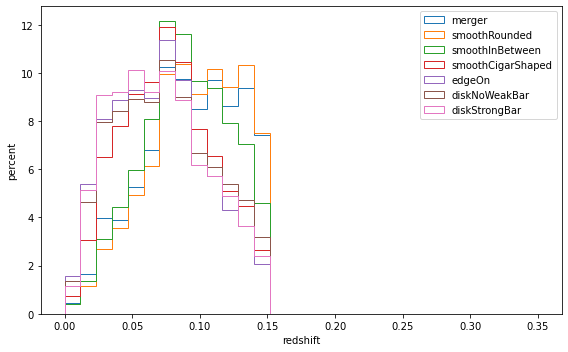

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.redshift,range=(1e-5,0.35), histtype="step", label = "merger", bins=30,density=True)
plt.hist(smoothRounded_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothRounded", bins=30,density=True)
plt.hist(smoothInBetween_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothInBetween", bins=30,density=True)
plt.hist(smoothCigarShaped_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothCigarShaped", bins=30,density=True)
plt.hist(edgeOn_in.redshift,range=(1e-5,0.35), histtype="step", label = "edgeOn", bins=30,density=True)
plt.hist(diskNoWeakBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "diskNoWeakBar", bins=30,density=True)
plt.hist(diskStrongBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "diskStrongBar", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

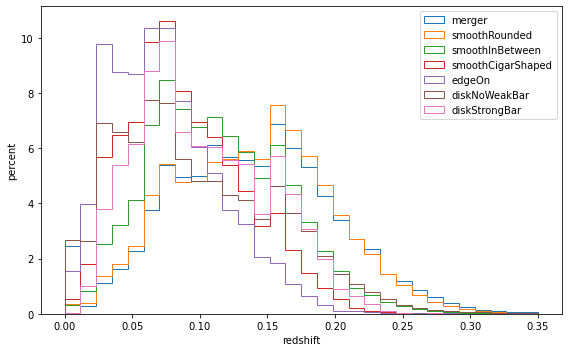

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(merger_out.z,range=(1e-5,0.35), histtype="step", label = "merger", bins=30,density=True)
plt.hist(smoothRounded_out.z,range=(1e-5,0.35), histtype="step", label = "smoothRounded", bins=30,density=True)
plt.hist(smoothInBetween_out.z,range=(1e-5,0.35), histtype="step", label = "smoothInBetween", bins=30,density=True)
plt.hist(smoothCigarShaped_out.z,range=(1e-5,0.35), histtype="step", label = "smoothCigarShaped", bins=30,density=True)
plt.hist(edgeOn_out.z,range=(1e-5,0.35), histtype="step", label = "edgeOn", bins=30,density=True)
plt.hist(diskNoWeakBar_out.z,range=(1e-5,0.35), histtype="step", label = "diskNoWeakBar", bins=30,density=True)
plt.hist(diskStrongBar_out.z,range=(1e-5,0.35), histtype="step", label = "diskStrongBar", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

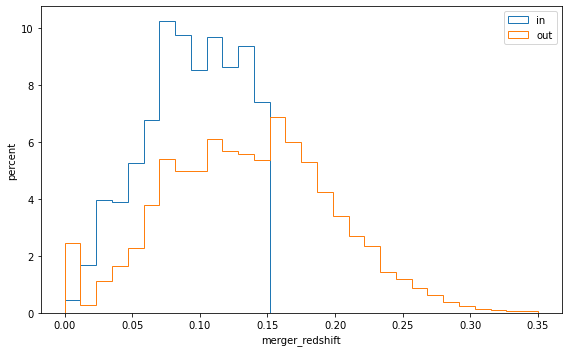

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(merger_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("merger_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

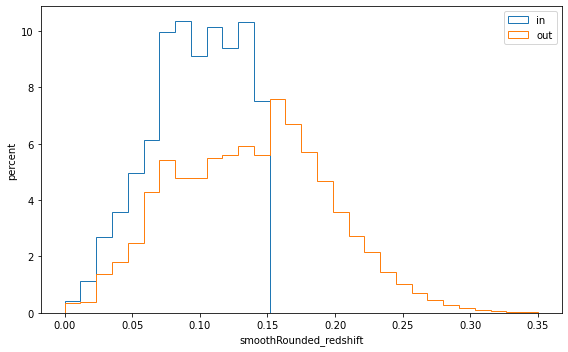

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(smoothRounded_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothRounded_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothRounded_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

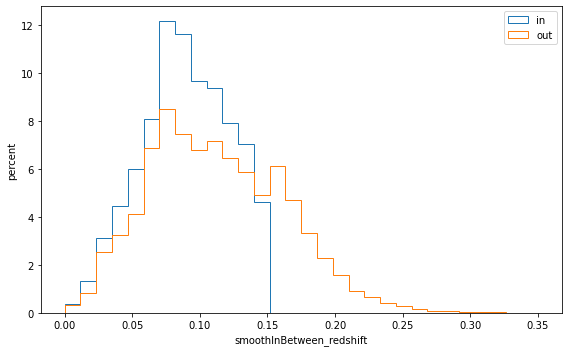

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(smoothInBetween_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothInBetween_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothInBetween_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

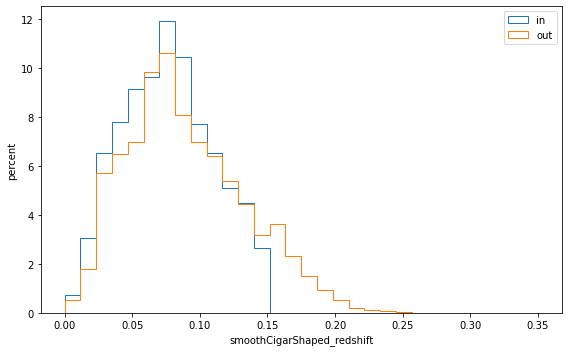

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(smoothCigarShaped_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothCigarShaped_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothCigarShaped_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

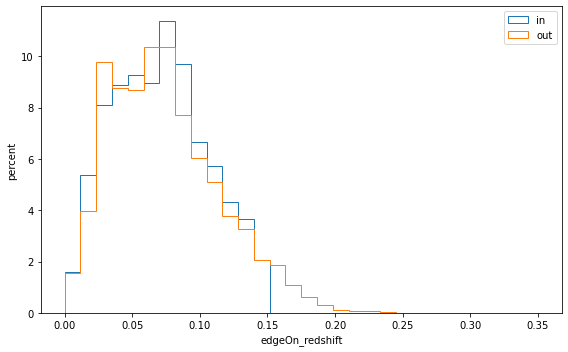

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(edgeOn_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(edgeOn_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("edgeOn_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

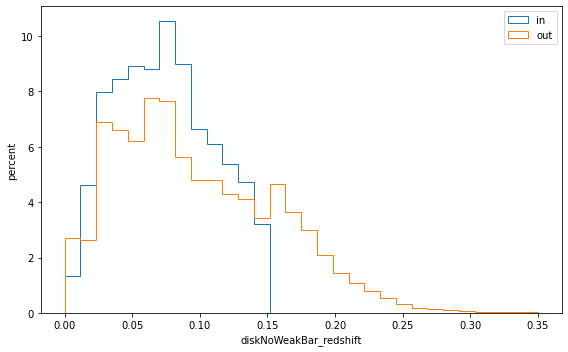

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(diskNoWeakBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(diskNoWeakBar_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("diskNoWeakBar_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

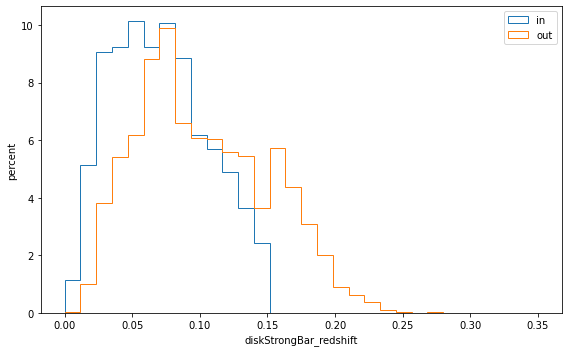

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(diskStrongBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(diskStrongBar_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("diskStrongBar_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

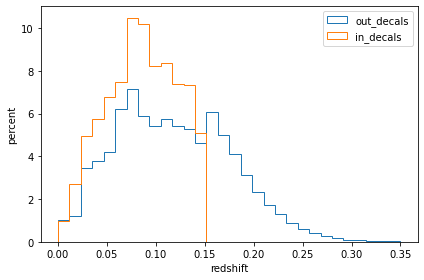

In [19]:
# plt.figure(figsize=(15, 10))
plt.hist(out.z,range=(1e-5,0.35), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.redshift,range=(1e-5,0.35), histtype="step", label = "in_decals", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

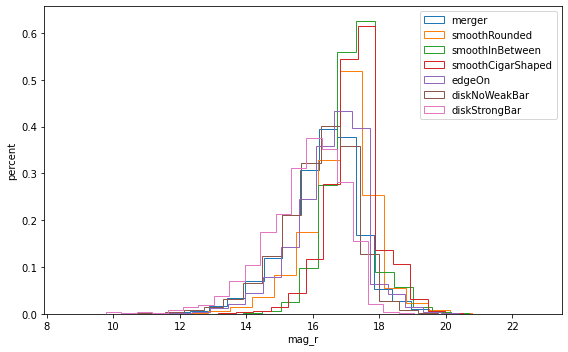

In [20]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.mag_r, histtype="step", label = "merger", bins=20,density=True)
plt.hist(smoothRounded_in.mag_r, histtype="step", label = "smoothRounded", bins=20,density=True)
plt.hist(smoothInBetween_in.mag_r, histtype="step", label = "smoothInBetween", bins=20,density=True)
plt.hist(smoothCigarShaped_in.mag_r, histtype="step", label = "smoothCigarShaped", bins=20,density=True)
plt.hist(edgeOn_in.mag_r, histtype="step", label = "edgeOn", bins=20,density=True)
diskNoWeakBar_plot = diskNoWeakBar_in.replace([np.inf, -np.inf], np.nan)
plt.hist(diskNoWeakBar_plot.mag_r, histtype="step", label = "diskNoWeakBar", bins=20,density=True)
plt.hist(diskStrongBar_in.mag_r, histtype="step", label = "diskStrongBar", bins=20,density=True)
plt.xlabel("mag_r")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

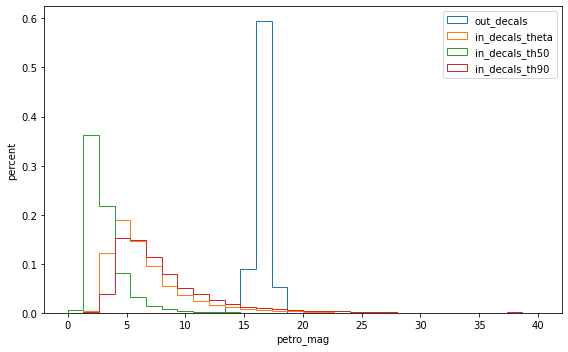

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(out.petro_mag,range=(1e-5,40), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.petro_theta,range=(1e-5,40), histtype="step", label = "in_decals_theta", bins=30,density=True)
plt.hist(df_auto.petro_th50,range=(1e-5,40), histtype="step", label = "in_decals_th50", bins=30,density=True)
plt.hist(df_auto.petro_th90,range=(1e-5,40), histtype="step", label = "in_decals_th90", bins=30,density=True)
plt.xlabel("petro_mag")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

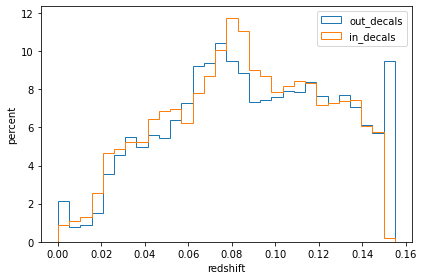

In [22]:
# plt.figure(figsize=(15, 10))
plt.hist(out.z,range=(1e-5,0.155), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.redshift,range=(1e-5,0.155), histtype="step", label = "in_decals", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

In [88]:
from tqdm import tqdm
ra = [str(i) for i in out.ra]
dec = [str(i) for i in out.dec]
for i in range(len(ra)):
    for j in range(1,5):
        if len(ra[i].split(".")[1]) == j:
            ra[i] += "0" * (5-j)
for i in range(len(dec)):
    for j in range(1,5):
        if len(dec[i].split(".")[1]) == j:
            dec[i] += "0" * (5-j)
z = list(out.z)
p = os.listdir("/data/renhaoye/decals_2022/out_decals/normalized_dat/")
full = []
short = []
for i in range(len(p)):
    x = p[i].split("_")[0]
    y = p[i].split("_")[1]
    full.append(str(x)+"_"+str(y))
    x = x.split(".")[0] + "." + x.split(".")[1][:resolution-1]
    y = y.split(".")[0] + "." + y.split(".")[1][:resolution-1]
    short.append(x + "_" + y)
for i in tqdm(range(len(z))):
# for i in tqdm(range(20)):
    if z[i]>0.15:
        query = short.index(str(ra[i]) + "_" + str(dec[i]))
        os.system("mv /data/renhaoye/decals_2022/out_decals/normalized_dat/%s /data/renhaoye/decals_2022/out_decals/zover015_dat/" % (full[query] + "_0.262_grz_raw.dat"))
        # print("mv /data/renhaoye/decals_2022/out_decals/normalized_dat/%s /data/renhaoye/decals_2022/out_decals/zover015_dat/" % (full[query] +"_0.262_grz_raw.dat"))

100%|█████████████████████████████████| 444220/444220 [7:29:06<00:00, 16.49it/s]
